#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento

# Final Project: NBA Outcome Predictions

NBA statistics can be very complex, so first, we will break down exactly what we are looking for.



## Fetch and Preprocess the data

In [164]:
import pandas as pd
import numpy as np
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import playercareerstats
from sklearn.preprocessing import LabelEncoder

# Fetch data
nba_teams = teams.get_teams()
team_abbr_to_id = {team['abbreviation']: team['id'] for team in nba_teams}
games_info = pd.DataFrame()

# Display all the columns
for team in nba_teams:
    team_id = team['id']
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable = team_id)
    games = gamefinder.get_data_frames()[0]
    games_info = pd.concat([games_info, games], ignore_index=True)
print(games_info.columns)

# Preprocess data
games_info['GAME_DATE'] = pd.to_datetime(games_info['GAME_DATE'])
games_info['WIN'] = games_info['WL'].apply(lambda x: 1 if x == 'W' else 0)
games_info['PTS'] = games_info['PTS'].astype(float)
games_info['Points_Per_Game'] = games_info.groupby('TEAM_ID')['PTS'].transform('mean')


Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')


In [165]:
# GET the OPPONENT_TEAM_ID from the MATCHUP
def get_opponent_team_id(matchup, team_abbr_to_id, team_id):
    if '@' in matchup:
        opponent_abbr = matchup.split(' @ ')[-1]
    else:
        opponent_abbr = matchup.split(' vs. ')[-1]
    return team_abbr_to_id.get(opponent_abbr, team_id)

games_info['OPPONENT_TEAM_ID'] = games_info.apply(
    lambda row: get_opponent_team_id(row['MATCHUP'], team_abbr_to_id, row['TEAM_ID']), axis=1
)

# Add HOME_GAME feature
games_info['HOME_GAME'] = games_info['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Add LAST_GAME_RESULT feature
games_info['LAST_GAME_RESULT'] = games_info.groupby('TEAM_ID')['WIN'].shift(1).fillna(0)


print(games_info.columns)

le = LabelEncoder()
games_info['TEAM_ID'] = le.fit_transform(games_info['TEAM_ID'])
games_info['OPPONENT_TEAM_ID'] = le.fit_transform(games_info['OPPONENT_TEAM_ID'])

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'WIN',
       'Points_Per_Game', 'OPPONENT_TEAM_ID', 'HOME_GAME', 'LAST_GAME_RESULT'],
      dtype='object')


## Normalization and Split Data

In [166]:
# Normalization
def normalize_columns(df, columns = []):
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

games_info = normalize_columns(games_info, ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'])

games_info

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,STL,BLK,TOV,PF,PLUS_MINUS,WIN,Points_Per_Game,OPPONENT_TEAM_ID,HOME_GAME,LAST_GAME_RESULT
0,22024,0,ATL,Atlanta Hawks,0022400030,2024-11-22,ATL @ CHI,L,240,1.406285,...,1.009833,-0.374965,-0.840875,-1.213089,-14.0,0,101.432026,4,0,0.0
1,22024,0,ATL,Atlanta Hawks,0022400258,2024-11-20,ATL @ GSW,L,238,-0.370305,...,0.356653,0.001763,0.571024,-1.008638,-23.0,0,101.432026,7,0,0.0
2,22024,0,ATL,Atlanta Hawks,0022400250,2024-11-18,ATL @ SAC,W,239,0.482458,...,-0.296526,0.755218,-0.134926,-0.599736,1.0,1,101.432026,21,0,0.0
3,22024,0,ATL,Atlanta Hawks,0022400239,2024-11-17,ATL @ POR,L,240,0.553522,...,0.683243,0.755218,2.453555,-0.599736,-4.0,0,101.432026,20,0,1.0
4,22024,0,ATL,Atlanta Hawks,0022400012,2024-11-15,ATL vs. WAS,W,240,1.903731,...,0.683243,1.885401,0.335707,-1.008638,12.0,1,101.432026,27,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106631,21988,29,CHH,Charlotte Hornets,0028800062,1988-11-12,CHH @ ATL,L,238,0.624586,...,1.336423,-1.128420,1.041656,0.831420,NaN,0,99.926358,0,0,0.0
106632,21988,29,CHH,Charlotte Hornets,0028800052,1988-11-11,CHH @ WAS,L,240,-1.080941,...,0.356653,-1.505147,1.982922,0.831420,NaN,0,99.926358,27,0,0.0
106633,21988,29,CHH,Charlotte Hornets,0028800024,1988-11-08,CHH vs. LAC,W,240,1.050967,...,0.356653,-1.505147,0.571024,1.853675,NaN,1,99.926358,9,1,0.0
106634,21988,29,CHH,Charlotte Hornets,0028800015,1988-11-05,CHH @ DET,L,240,-1.223068,...,0.030064,0.378490,-0.840875,-0.190834,NaN,0,99.926358,28,0,1.0


In [167]:
# Split data into the respective team files so that we can 
# refer to them to feed the appropriate data to the model

def create_team_csv_files(df, column = 'TEAM_ABBREVIATION'):
    for team in df[column].unique():
        team_df = df.loc[df[column] == team]
        team_df.to_csv('team_data/' + team + '.csv', index=False)

create_team_csv_files(games_info)

### With our csv files now created to refer to, we can read from them and feed the appropriate data to the model. However, some manipulation needs to be done first that would cause the size of the CSV files to be unnecessarily large.

In [168]:
team1 = "LAL"
df_team1 = pd.read_csv('team_data/' + team1 + '.csv')

df_team1

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,STL,BLK,TOV,PF,PLUS_MINUS,WIN,Points_Per_Game,OPPONENT_TEAM_ID,HOME_GAME,LAST_GAME_RESULT
0,22024,10,LAL,Los Angeles Lakers,22400270,2024-11-23,LAL vs. DEN,L,239,-0.014987,...,1.009833,-0.751692,0.100391,-1.213089,-25.0,0,105.09995,6,1,0.0
1,22024,10,LAL,Los Angeles Lakers,22400263,2024-11-21,LAL vs. ORL,L,240,1.122031,...,-1.276296,0.378490,-1.076192,-1.417540,-1.0,0,105.09995,16,1,0.0
2,22024,10,LAL,Los Angeles Lakers,22400026,2024-11-19,LAL vs. UTA,W,240,1.548412,...,0.356653,0.001763,-0.134926,-1.213089,6.0,1,105.09995,25,1,0.0
3,22024,10,LAL,Los Angeles Lakers,22400231,2024-11-16,LAL @ NOP,W,240,0.127140,...,0.683243,-0.751692,-0.840875,-1.621991,5.0,1,105.09995,3,0,1.0
4,22024,10,LAL,Los Angeles Lakers,22400015,2024-11-15,LAL @ SAS,W,241,1.264158,...,0.683243,-0.751692,-1.076192,-2.235344,5.0,1,105.09995,22,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3987,21983,10,LAL,Los Angeles Lakers,28300066,1983-11-08,LAL @ DEN,W,240,2.187985,...,1.009833,1.131946,1.982922,1.853675,NaN,1,105.09995,6,0,1.0
3988,21983,10,LAL,Los Angeles Lakers,28300053,1983-11-05,LAL @ DAL,L,240,-0.014987,...,-0.296526,1.131946,1.276973,1.035871,NaN,0,105.09995,5,0,1.0
3989,21983,10,LAL,Los Angeles Lakers,28300035,1983-11-02,LAL @ SDC,L,240,0.269267,...,1.989602,0.755218,2.218239,0.422518,NaN,0,105.09995,10,0,0.0
3990,21983,10,LAL,Los Angeles Lakers,28300010,1983-10-29,LAL @ UTH,W,240,1.264158,...,0.683243,1.885401,1.276973,3.898184,NaN,1,105.09995,10,0,0.0


In [169]:
# Split Data into X and y, where y is the target var (win/loss)
from sklearn.model_selection import train_test_split

X = games_info[['TEAM_ID', 'OPPONENT_TEAM_ID', 'Points_Per_Game', 'HOME_GAME', 'LAST_GAME_RESULT']]
y = games_info['WIN']  # Target variable (win/loss)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of training and test sets
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

Training features shape: (74645, 5)
Test features shape: (31991, 5)


## **#1. Initialize and train the Random Forest Classifier**
This initializes a RandomForestClassifier, where n_estimators set to 100 (the number of decision trees in the forest). Increasing this generally improves the performance of the model. This will now create 100 decision trees while training on the given dataset and will select the best one based on majority voting.

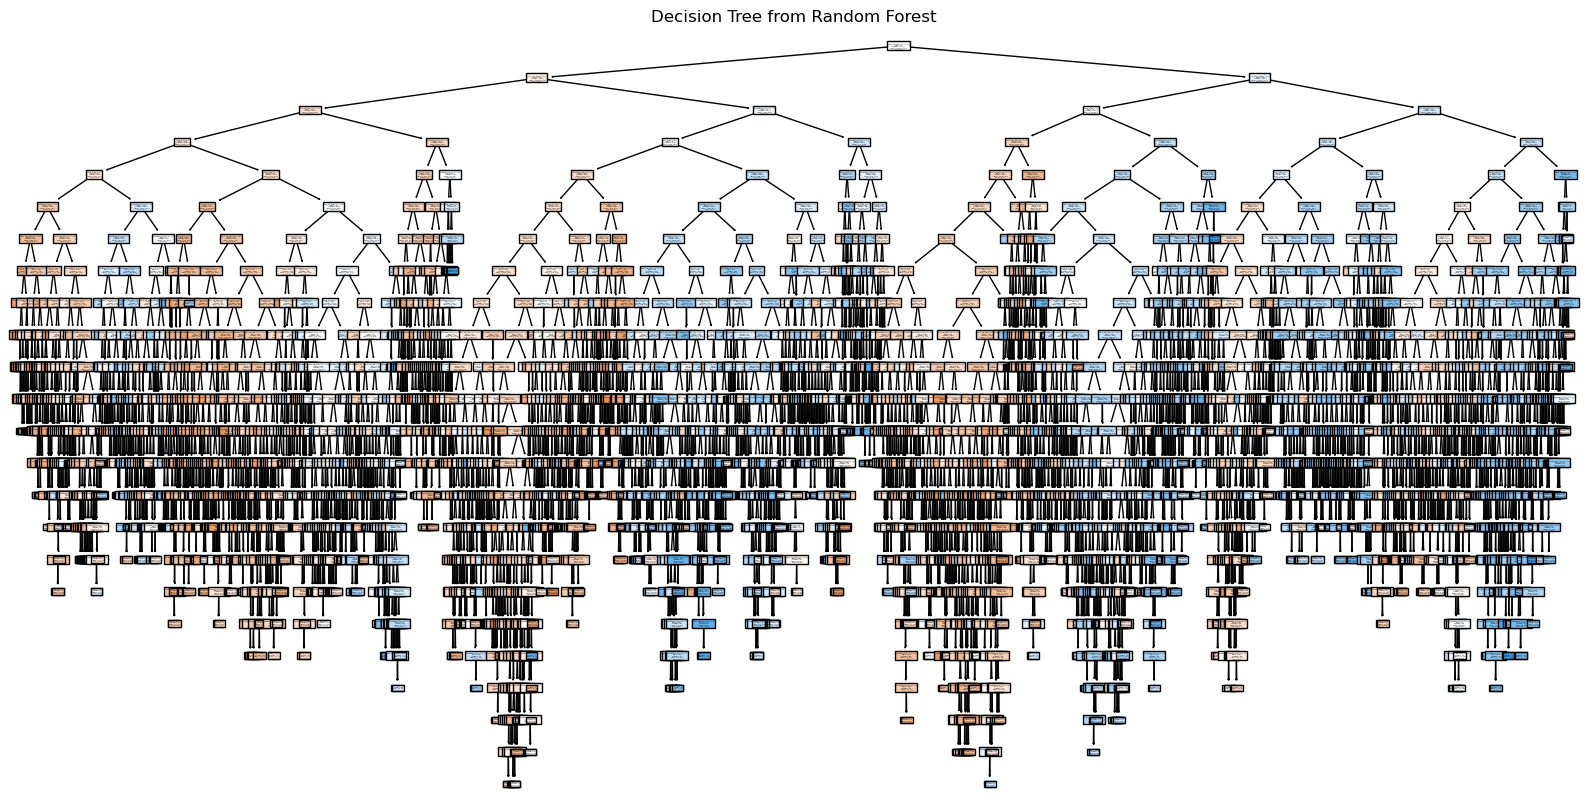

In [170]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)


# Extract a single tree from the Random Forest
single_tree = forest_model.estimators_[0]  # Get the first tree in the forest

# Define feature names and class names
input_features = ['TEAM_ID', 'OPPONENT_TEAM_ID', 'Points_Per_Game', 'HOME_GAME', 'LAST_GAME_RESULT']
class_names = ['LOSE', 'WIN']

# Plot the single decision tree
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          filled=True, 
          feature_names=input_features, 
          class_names=class_names)
plt.title("Decision Tree from Random Forest")
plt.show()

## Evaluate the Model

In [171]:
y_pred = forest_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['LOSE', 'WIN']))

Accuracy: 0.5885405270232252
              precision    recall  f1-score   support

        LOSE       0.59      0.60      0.59     16007
         WIN       0.59      0.58      0.58     15984

    accuracy                           0.59     31991
   macro avg       0.59      0.59      0.59     31991
weighted avg       0.59      0.59      0.59     31991



In [172]:
# Fetching team abreviations for reference

from nba_api.stats.static import teams

nba_teams = teams.get_teams()

# Extract team abbreviations
team_abbreviations = [team['abbreviation'] for team in nba_teams]
print("Team Abbreviations:", team_abbreviations)

Team Abbreviations: ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL', 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']


## Feature Importance
This will help us gain insights into which factors most influence game outcomes. Now, the below will extract features importances from the trained Random Forest Classifier. 

In [173]:
feature_importances = pd.DataFrame(forest_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# Each feature will be ranked based on its influence 
print("Feature Importances:\n", feature_importances)
     

Feature Importances:
                   importance
OPPONENT_TEAM_ID    0.517525
HOME_GAME           0.270191
Points_Per_Game     0.092578
TEAM_ID             0.079195
LAST_GAME_RESULT    0.040511


## Predictions and Results

In [174]:
team_abbr = 'LAL'
opponent_abbr = 'CHI'

average_points_per_game = 110.5  # Replace with the actual average points per game

new_data = pd.DataFrame({
    'TEAM_ID': [le.transform([team_abbr_to_id[team_abbr]])[0]],
    'OPPONENT_TEAM_ID': [le.transform([team_abbr_to_id[opponent_abbr]])[0]],
    'Points_Per_Game': [average_points_per_game],
    'HOME_GAME': [1],  # Replace with 1 if home game, else 0
    'LAST_GAME_RESULT': [1]  # Replace with last game result (1 if win, 0 if loss)
})

predictions = forest_model.predict(new_data)
prediction_probabilities = forest_model.predict_proba(new_data)

print("Predictions: ", predictions) # Outputs 1 if our team wins

# Convert probabilities to percentages
percentages = prediction_probabilities * 100

# Format and print the percentages
for idx, prediction in enumerate(percentages):
    print(f"Prediction Probabilities: [Loss - {prediction[0]:.2f}%], [Win - {prediction[1]:.2f}%]")


Predictions:  [1]
Prediction Probabilities: [Loss - 34.58%], [Win - 65.42%]


## **#2. Initialize and Train the Decision Tree Classifier**
This code initializes a DecisionTreeClassifier with a max_depth of 3, which limits the depth of the tree to ensure simplicity and reduce the risk of overfitting. Unlike ensembles like Random Forest, which combine multiple decision trees, this model creates and uses a single decision tree to make predictions.

During training, the model splits the data based on the most informative features (e.g., TEAM_ID, OPPONENT_TEAM_ID, Points_Per_Game, etc.) and constructs a tree structure where each internal node represents a decision rule, and the leaf nodes represent the predicted class (LOSE or WIN). The random_state=42 ensures that results are reproducible by controlling the randomness in the training process.

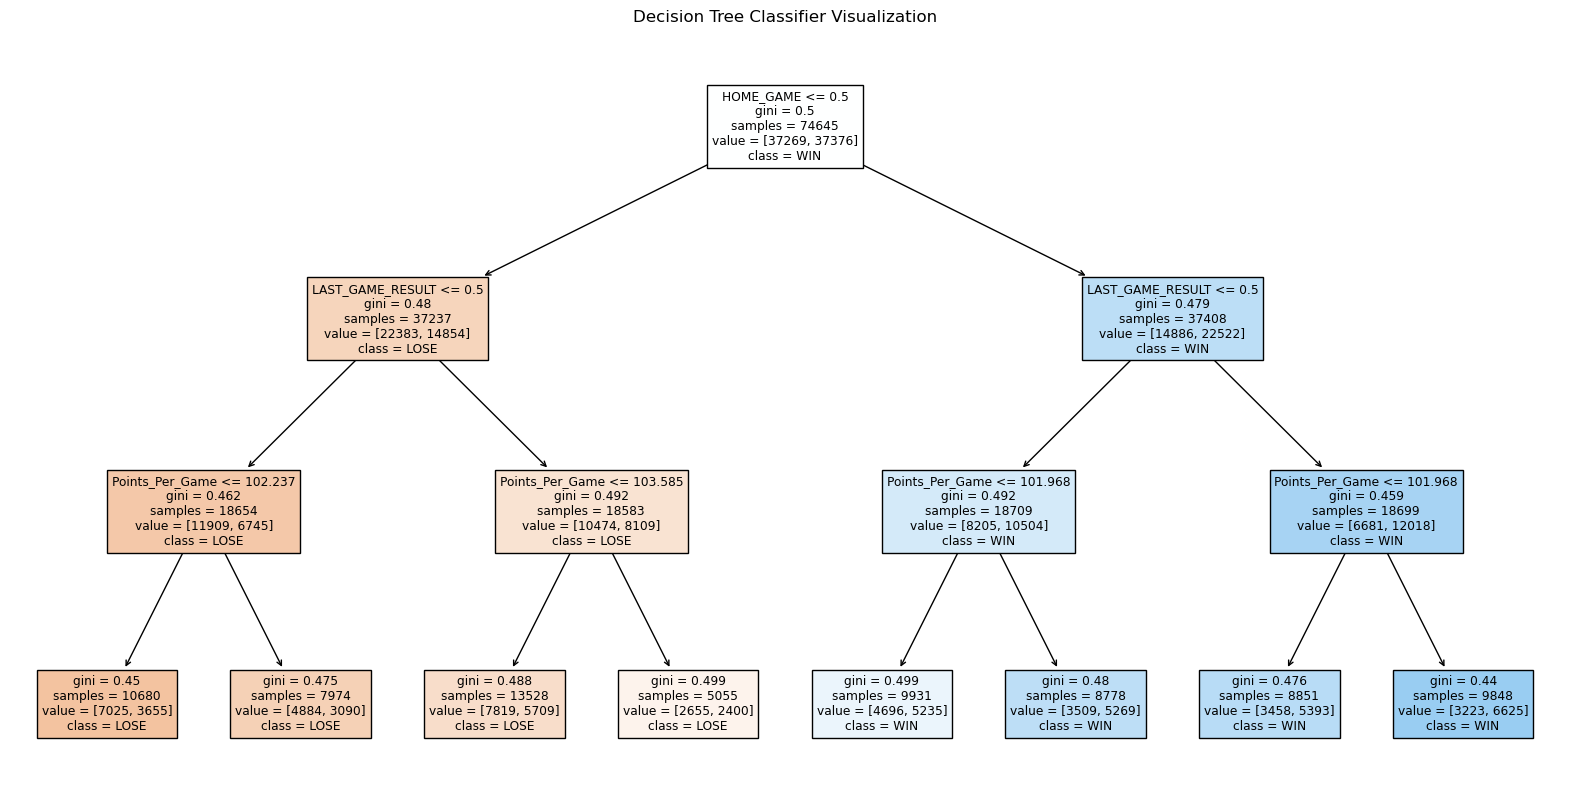

In [175]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Instantiate the decision tree classifier
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

input_features = ['TEAM_ID', 'OPPONENT_TEAM_ID', 'Points_Per_Game', 'HOME_GAME', 'LAST_GAME_RESULT']
class_names = ['LOSE', 'WIN']  

# Plot the decision tree 
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plot_tree(tree_model, 
          filled=True, 
          feature_names=input_features,  # important feature column names
          class_names=class_names)
plt.title("Decision Tree Classifier Visualization")
plt.show()



## Evaluate the Model

In [176]:
y_pred = tree_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['LOSE', 'WIN']))

Accuracy: 0.604451251914601
              precision    recall  f1-score   support

        LOSE       0.60      0.61      0.61     16007
         WIN       0.60      0.60      0.60     15984

    accuracy                           0.60     31991
   macro avg       0.60      0.60      0.60     31991
weighted avg       0.60      0.60      0.60     31991



## Predictions and Results

In [183]:
# Input team abbreviations
team_abbr = 'LAL'
opponent_abbr = 'CHI'

# Validate the input abbreviations
if team_abbr not in team_abbr_to_id or opponent_abbr not in team_abbr_to_id:
    print(f"Invalid team abbreviation(s): {team_abbr}, {opponent_abbr}")
else:
    # Get corresponding IDs
    team_id = team_abbr_to_id[team_abbr]
    opponent_id = team_abbr_to_id[opponent_abbr]
    
    # Filter the dataset
    filtered_data = X_test[
        (X_test['TEAM_ID'] == team_id) &
        (X_test['OPPONENT_TEAM_ID'] == opponent_id)
    ]
    
    # Check if there's data
    if filtered_data.empty:
        print(f"No data available for the matchup between {team_abbr} and {opponent_abbr}.")
    else:
        # Make predictions
        predictions = tree_model.predict(filtered_data)
        prediction_probabilities = tree_model.predict_proba(filtered_data)
        
        # Display predictions
        for idx, (prediction, probabilities) in enumerate(zip(predictions, prediction_probabilities)):
            print(f"Prediction: {'WIN' if prediction == 1 else 'LOSE'}")
            print(f"Prediction Probabilities: [Loss - {probabilities[0] * 100:.2f}%], [Win - {probabilities[1] * 100:.2f}%]")


No data available for the matchup between LAL and CHI.
